# 608 Project Update - Predicting bots without network characteristics

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import sklearn.svm as svm
from sklearn.model_selection import train_test_split

In [2]:
# feature ideas
# score per comment DONE
# standard deviation of minute posted (bots have low standard deviation - not random) DONE
# change in sentiment within each topic (users are consistent)
# change in length of comment (bots are consistent) DONE
# number of unique words used normalized by length of comment (users use more varied vocabulary)
# variation in amount of different subreddits (users are more varied) DONE

In [2]:
bot_comments = pd.read_csv("bot_comments_text.csv")
bot_comments.head()

,body,author,created_utc,link_id,parent_id,score,id,subreddit
0,"Sorry, your [submission](https://www.reddit.co...",AutoModerator,1540476773,t3_9ranyu,t3_9ranyu,1,e8fct3m,stocks
1,Classic instance of confirmation bias confirmed,_Serene_,1538666992,t3_9lasi9,t1_e75a4xf,-19,e75noth,2007scape
2,Please review the subreddit rules in the sideb...,ModeratelyHelpfulBot,1540564985,t3_9rla3j,t3_9rla3j,1,e8hp6a3,BDSMpersonals
3,Progress for the sake of progress. ok.,GreatSuperPie,1540565025,t3_9rl1qc,t1_e8hork7,-15,e8hp7wu,ukpolitics
4,\n[Arcanis the Omnipotent](https://img.scryf...,MTGCardFetcher,1540565095,t3_9rci7g,t1_e8hpa25,1,e8hpau3,EDH


In [3]:
user_comments = pd.read_csv("user_comments_text.csv")
user_comments.head()

,body,author,created_utc,link_id,parent_id,score,id,subreddit
0,Ah I used to dumpster dive in the early 2000 e...,anonymous_opinions,1539993442,t3_9pn0cq,t1_e83bwq0,1,e83ckvy,MakeupAddiction
1,you're probably under leveled. Spend a few day...,Kevin69138,1539993555,t3_9pp2aq,t3_9pp2aq,2,e83comt,bloodborne
2,One Ben Askren = One Mighty Mouse,Ronanfob,1540402079,t3_9r1lxk,t1_e8dby14,120,e8dckfm,MMA
3,I’m convinced that whoever wrote the section o...,BicepBandito,1540402120,t3_9qoq61,t1_e8d9lza,1,e8dcmej,steroids
4,I'm gonna go with my gut here and up-vote you ...,ytzi13,1540402173,t3_9qw7t7,t1_e8d26l5,-2,e8dcp17,RocketLeague


In [4]:
user_comments['time_posted'] = pd.to_datetime(user_comments.created_utc, unit='s')
bot_comments['time_posted'] = pd.to_datetime(bot_comments.created_utc, unit='s')

In [5]:
user_comments['hour'] = user_comments.time_posted.dt.hour
bot_comments['hour'] = bot_comments.time_posted.dt.hour
user_comments['minute'] = user_comments.time_posted.dt.minute
bot_comments['minute'] = bot_comments.time_posted.dt.minute

In [6]:
user_comments['num_words'] = user_comments.body.apply(str).apply(str.split).apply(len)
bot_comments['num_words'] = bot_comments.body.apply(str).apply(str.split).apply(len)

In [8]:
user_comments.head(20)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,time_posted,hour,minute,num_words
0,Ah I used to dumpster dive in the early 2000 e...,anonymous_opinions,1539993442,t3_9pn0cq,t1_e83bwq0,1,e83ckvy,MakeupAddiction,2018-10-19 23:57:22,23,57,62
1,you're probably under leveled. Spend a few day...,Kevin69138,1539993555,t3_9pp2aq,t3_9pp2aq,2,e83comt,bloodborne,2018-10-19 23:59:15,23,59,11
2,One Ben Askren = One Mighty Mouse,Ronanfob,1540402079,t3_9r1lxk,t1_e8dby14,120,e8dckfm,MMA,2018-10-24 17:27:59,17,27,7
3,I’m convinced that whoever wrote the section o...,BicepBandito,1540402120,t3_9qoq61,t1_e8d9lza,1,e8dcmej,steroids,2018-10-24 17:28:40,17,28,83
4,I'm gonna go with my gut here and up-vote you ...,ytzi13,1540402173,t3_9qw7t7,t1_e8d26l5,-2,e8dcp17,RocketLeague,2018-10-24 17:29:33,17,29,13
5,OH SHIT. Flag is up!,Haboob_AZ,1540402209,t3_9r1exu,t3_9r1exu,2,e8dcqrn,soccer,2018-10-24 17:30:09,17,30,5
6,hoping the comments aren't some dumb algorithm...,habs76,1540589895,t3_9rovd0,t3_9rovd0,1,e8iivdm,ChapoTrapHouse,2018-10-26 21:38:15,21,38,11
7,Saying that some people aren't human beings is...,derangeddollop,1540589926,t3_9roi7b,t1_e8ii9v9,27,e8iiwjc,ChapoTrapHouse,2018-10-26 21:38:46,21,38,9
8,"Because you, people, can never appreciate a go...",Support_For_Life,1540590094,t3_9ri2l2,t1_e8h4n3j,1,e8ij2zm,killingfloor,2018-10-26 21:41:34,21,41,25
9,yes music cuts off and you endup with the void...,echo1956,1540590247,t3_9ro9s9,t1_e8ifw2m,4,e8ij8wh,TheOCS,2018-10-26 21:44:07,21,44,20


In [7]:
user = pd.DataFrame(pd.Series(user_comments.groupby('author').size()), columns=['num_comments'])
user['mean_score'] = user_comments.groupby('author')[["score"]].mean()
user['std_minute'] = user_comments.groupby('author')[["minute"]].std()
user['std_num_words'] = user_comments.groupby('author')[['num_words']].std()
user['num_unique_subs'] = user_comments.groupby('author')[["subreddit"]].describe()[("subreddit", "unique")]

In [8]:
user["unique_subs_per_comment"] = pd.to_numeric(user.num_unique_subs / user.num_comments)
user.head()

,num_comments,mean_score,std_minute,std_num_words,num_unique_subs,unique_subs_per_comment
author,,,,,,
--lily--,145,5.131034,17.473987,17.015679,34,0.234483
-4-a-,72,16.222222,16.749816,17.520159,33,0.458333
-ALady,66,3.424242,16.507934,94.252995,1,0.015152
-ArchitectOfThought-,72,1.750000,17.132179,68.117247,17,0.236111
-Captain-,79,6.645570,17.648043,21.778144,21,0.265823


In [9]:
bot = pd.DataFrame(pd.Series(bot_comments.groupby('author').size()), columns=['num_comments'])
bot['mean_score'] = bot_comments.groupby('author')[["score"]].mean()
bot['std_minute'] = bot_comments.groupby('author')[["minute"]].std()
bot['std_num_words'] = bot_comments.groupby('author')[['num_words']].std()
bot['num_unique_subs'] = bot_comments.groupby('author')[["subreddit"]].describe()[("subreddit", "unique")]

In [11]:
bot["unique_subs_per_comment"] = pd.to_numeric(bot.num_unique_subs / bot.num_comments)
bot.head()

,num_comments,mean_score,std_minute,std_num_words,num_unique_subs,unique_subs_per_comment
author,,,,,,
-1KingKRool-,17,4.647059,17.165072,18.511920,12,0.705882
-RStyle,11,5.909091,18.127327,15.328524,3,0.272727
-SgtSpaghetti-,23,3.086957,19.212459,6.597700,11,0.478261
-___-___-__-___-___-,16,13.500000,16.753109,10.550671,10,0.625000
-eDgAR-,33,924.000000,15.725149,147.137227,5,0.151515


In [13]:
max(user.unique_subs_per_comment)

0.8913043478260869

/Users/bensadis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


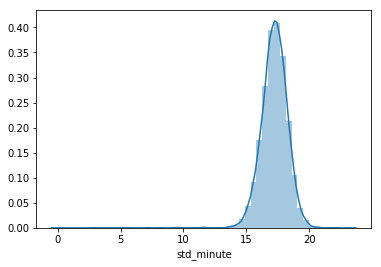

In [29]:
sns.distplot(user.query("num_comments > 15").std_minute)

/Users/bensadis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


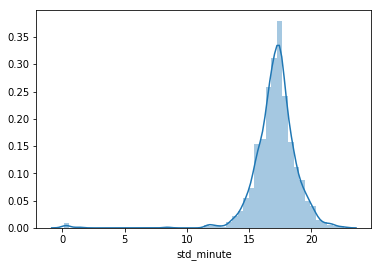

In [28]:
sns.distplot(bot.query("num_comments > 15").std_minute.dropna())

In [142]:
user_comments.groupby('author')[["subreddit"]].describe()[("subreddit", "unique")]

author
--lily--                145
-4-a-                    72
-ALady                   66
-ArchitectOfThought-     72
-Captain-                79
-Codiak-                 69
-Dargon-                 54
-Don-Draper-            105
-GroovyChick-           129
-Kite-Man-              109
-Mamba-                  68
-Mochaccina-             74
-Mountain-King-          63
-RedditCat-              55
-SuchWow-                64
-TheMasterSoldier-       85
-Tilde                   49
-UserRemoved-            89
-Vulcan17-               75
-_-_-_-____----____-     66
-h-e-c-k-                66
-jjjjjjjjjj-             58
-jute-                   83
-life_starts_now-        58
-notsopettylift3r-       68
-poop-in-the-soup-       66
-weirdo-                 50
00000000000001000000     77
000TragicSolitude        50
0110110101100010         65
                       ... 
zaphod_beeble_bro        72
zappy487                 65
zarco92                  79
zaviex                   51
zbeezle      

In [47]:
bot_comments.head(20)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,time_posted,hour,minute
0,"Sorry, your [submission](https://www.reddit.co...",AutoModerator,1540476773,t3_9ranyu,t3_9ranyu,1,e8fct3m,stocks,2018-10-25 14:12:53,14,12
1,Classic instance of confirmation bias confirmed,_Serene_,1538666992,t3_9lasi9,t1_e75a4xf,-19,e75noth,2007scape,2018-10-04 15:29:52,15,29
2,Please review the subreddit rules in the sideb...,ModeratelyHelpfulBot,1540564985,t3_9rla3j,t3_9rla3j,1,e8hp6a3,BDSMpersonals,2018-10-26 14:43:05,14,43
3,Progress for the sake of progress. ok.,GreatSuperPie,1540565025,t3_9rl1qc,t1_e8hork7,-15,e8hp7wu,ukpolitics,2018-10-26 14:43:45,14,43
4,\n[Arcanis the Omnipotent](https://img.scryf...,MTGCardFetcher,1540565095,t3_9rci7g,t1_e8hpa25,1,e8hpau3,EDH,2018-10-26 14:44:55,14,44
5,"\nAs a reminder, this subreddit [is for civil ...",AutoModerator,1540477177,t3_9raq30,t3_9raq30,1,e8fd99h,politics,2018-10-25 14:19:37,14,19
6,"\nAs a reminder, this subreddit [is for civil ...",AutoModerator,1540477482,t3_9rarkz,t3_9rarkz,1,e8fdlpv,politics,2018-10-25 14:24:42,14,24
7,"If this is a dank meme, **Upvote** this comme...",KeepingDankMemesDank,1538574803,t3_9l1cbx,t3_9l1cbx,1,e738mro,dankmemes,2018-10-03 13:53:23,13,53
8,\n\n\n[***Other People's Choices***](https://a...,FanfictionBot,1539538805,t3_9o10w0,t1_e7raxq9,3,e7razh5,HPfanfiction,2018-10-14 17:40:05,17,40
9,"Hey lynn02manson528, your submission will need...",AutoModerator,1539538830,t3_9o4ny2,t3_9o4ny2,1,e7rb0is,youtube,2018-10-14 17:40:30,17,40


In [175]:
# create dictionary of all users
user_dict = {}
for i, row in user_comments.iterrows():
    if i % 100000 == 0: print(i)
    user = row.author
    if user in user_dict:
        user_dict[user]['num_comments'] += 1
        user_dict[user]['total_score'] += row.score
    else:
        user_dict[user] = {'num_comments': 1, 'total_score': row.score}

0
100000
200000
300000
400000
500000
600000
700000
800000


In [176]:
# create dictionary of all bots
bot_dict = {}
for i, row in bot_comments.iterrows():
    if i % 100000 == 0: print(i)
    bot = row.author
    if bot in bot_dict:
        bot_dict[bot]['num_comments'] += 1
        bot_dict[bot]['total_score'] += row.score
    else:
        bot_dict[bot] = {'num_comments': 1, 'total_score': row.score}

0
100000
200000


## Machine Learning

In [33]:
# concatenate user and bot dataframes
user = user.assign(is_bot = 0)
bot = bot.assign(is_bot = 1)
data = pd.concat([user, bot])

In [34]:
# only use users with sufficient data
data = data.query("num_comments >= 15")

In [35]:
len(data.query("is_bot == 1"))

1124

In [36]:
train, test = train_test_split(data, test_size = 0.3)

In [38]:
Cs = [1, 10, 100, 1000, 10000]
gammas = [0.0001, 0.001, 0.01, 0.1]

for C in Cs:
    for gamma in gammas:
        print(C)
        print(gamma)
        clf = svm.SVC(kernel='rbf', class_weight='balanced', C=C, gamma=gamma)
        clf.fit(train.loc[:,("mean_score", "std_minute", "std_num_words", "unique_subs_per_comment")], train.is_bot)
        pred = clf.predict(test.loc[:,("mean_score", "std_minute", "std_num_words", "unique_subs_per_comment")])
        labels = pd.DataFrame(test.is_bot)
        labels["pred"] = pred
        sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
        spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
        print(sens)
        print(spec)
        print((sens + spec) / 2)

1
0.0001
0.49554896142433236
0.6731089636787737
0.5843289625515531
1
0.001
0.4362017804154303
0.7420859713428857
0.589143875879158
1
0.01
0.5074183976261127
0.7317560813062313
0.619587239466172
1
0.1
0.456973293768546
0.7704098633788737
0.6136915785737098
10
0.0001
0.42136498516320475
0.7707430856381207
0.5960540354006627
10
0.001
0.5044510385756676
0.8160613128957014
0.6602561757356845
10
0.01
0.5252225519287834
0.7820726424525158
0.6536475971906497
10
0.1
0.39465875370919884
0.8040653115628124
0.5993620326360056
100
0.0001
0.5341246290801187
0.8127290903032323
0.6734268596916755
100
0.001
0.516320474777448
0.8190603132289237
0.6676903940031859
100
0.01
0.5133531157270029
0.793735421526158
0.6535442686265804
100
0.1
0.3560830860534125
0.8133955348217261
0.5847393104375693
1000
0.0001
0.5667655786350149
0.8023992002665779
0.6845823894507963
1000
0.001
0.5341246290801187
0.8110629790069976
0.6725938040435582
1000
0.01
0.5044510385756676
0.813728757080973
0.6590898978283204
1000
0.1
0.33

In [62]:
pred = clf.predict(test.loc[:,("mean_score", "std_minute", "std_num_words", "unique_subs_per_comment")])

In [63]:
len(pred)

3338

In [64]:
labels = pd.DataFrame(test.is_bot)
labels["pred"] = pred

In [65]:
len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))

0.21264367816091953

In [66]:
len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))

0.8859531772575251

In [209]:
train.loc[:,("mean_score", "std_minute", "std_num_words", "unique_subs_per_comment")]

,mean_score,std_minute,std_num_words,unique_subs_per_comment
author,,,,
mfg_colour,6.316456,17.842753,67.676191,0.240506
MalcolmX_InTheMiddle,8.379310,17.505716,19.875322,0.120690
NFLLIVE2018TV,1.000000,9.308289,10.649230,0.008696
Maxpowr9,10.513889,17.108815,18.777973,0.111111
ReverseLazarus,4.099099,17.041977,24.966110,0.054054
plumbtree,4.362319,18.249420,23.118961,0.101449
RearEchelon,8.142857,19.628675,41.863075,0.632653
Stebro1986,8.467532,17.492905,164.271601,0.025974
Tux1,4.957746,17.685720,6.532599,0.352113
